In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import holidays
import warnings


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 20})

train_csv = 'playground-series-s5e1/train.csv'
test_csv = 'playground-series-s5e1/test.csv'


In [3]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [4]:
train_df.date = pd.DatetimeIndex(train_df.date)
train_df['test'] = 0
test_df.date = pd.DatetimeIndex(test_df.date)
test_df['test'] = 1

In [5]:
class CFG:
    years_train = train_df.date.dt.year.unique()
    years_test = test_df.date.dt.year.unique()
    years = np.concatenate([train_df.date.dt.year.unique(), test_df.date.dt.year.unique()])

    validation = 2000

    countries = train_df.country.unique()
    stores = train_df.store.unique()
    products = train_df['product'].unique()

    alpha3 = {'Finland': 'FIN', 'Canada': 'CAN', 'Italy': 'IT', 'Kenya': 'KEN', 'Singapore': 'SGP', 'Norway': 'NOR'}

    fft_filter_width = 8

    countries_2l = {'Finland': 'FI', 'Canada': 'CA', 'Italy': 'IT', 'Kenya': 'KE', 'Singapore': 'SG', 'Norway': 'NO'}
    holiday_response_len = 10

In [6]:
df = pd.concat([train_df, test_df], axis=0)
df.date = pd.DatetimeIndex(df.date)
df['year'] = df.date.dt.year
df['weekday'] = df.date.dt.weekday
df['month'] = df.date.dt.month
df['dayofyear'] = df['date'].dt.dayofyear
df['daynum'] = (df.date - df.date.iloc[0]).dt.days
df['weeknum'] = df['daynum'] // 7
df['daynum'] = df.date.dt.day

In [7]:
daysinyear = (df.groupby('year').id.count() / len(CFG.countries) / len(CFG.stores) / len(CFG.products)).rename('daysinyear').astype(int).to_frame()

In [8]:
df = df.join(daysinyear, on='year', how='left')
df['partofyear'] = (df['dayofyear'] - 1) / df['daysinyear']
df['partof2year'] = df['partofyear'] + df['year'] % 2
df['partof2year'] = df['partofyear'] + df['year'] % 2

CFG.sincoscol = [f'sin t', f'cos t', f'sin t/2', f'cos t/2']
CFG.sincoscol2 = [f'sin 2t', f'cos 2t', f'sin t', f'cos t', f'sin t/2', f'cos t/2']
df['sin 4t'] = np.sin(8 * np.pi * df['partofyear'])
df['cos 4t'] = np.cos(8 * np.pi * df['partofyear'])
df['sin 3t'] = np.sin(6 * np.pi * df['partofyear'])
df['cos 3t'] = np.cos(6 * np.pi * df['partofyear'])
df['sin 2t'] = np.sin(4 * np.pi * df['partofyear'])
df['cos 2t'] = np.cos(4 * np.pi * df['partofyear'])
df['sin t'] = np.sin(2 * np.pi * df['partofyear'])
df['cos t'] = np.cos(2 * np.pi * df['partofyear'])
df['sin t/2'] = np.sin(np.pi * df['partof2year'])
df['cos t/2'] = np.cos(np.pi * df['partof2year'])
df.drop(['daysinyear', 'partofyear', 'partof2year'], axis=1, inplace=True)

In [9]:
import requests
def get_gdp_per_capita(country,year):
    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(CFG.alpha3[country],year)
    response = requests.get(url).json()
    return response[1][0]['value']

# gdp[counties x years]
gdp = np.array([[get_gdp_per_capita(country, year) for year in CFG.years] for country in CFG.countries])
gdp_df = pd.DataFrame(gdp, index=train_df.country.unique(), columns=CFG.years)

df['gdp_factor'] = None
for year in CFG.years:
    for country in CFG.countries:
        df.loc[(df.country == country) & (df.year == year), 'gdp_factor'] = gdp_df.loc[country, year]

In [10]:
df_no_can_ken = df[~df.country.isin(('Canada', 'Kenya'))]

store_df = df_no_can_ken.groupby(by='store').num_sold.mean().rename('store_factor').to_frame()
df = df.drop('store_factor', axis=1, errors='ignore').join(store_df, on='store', how='left')

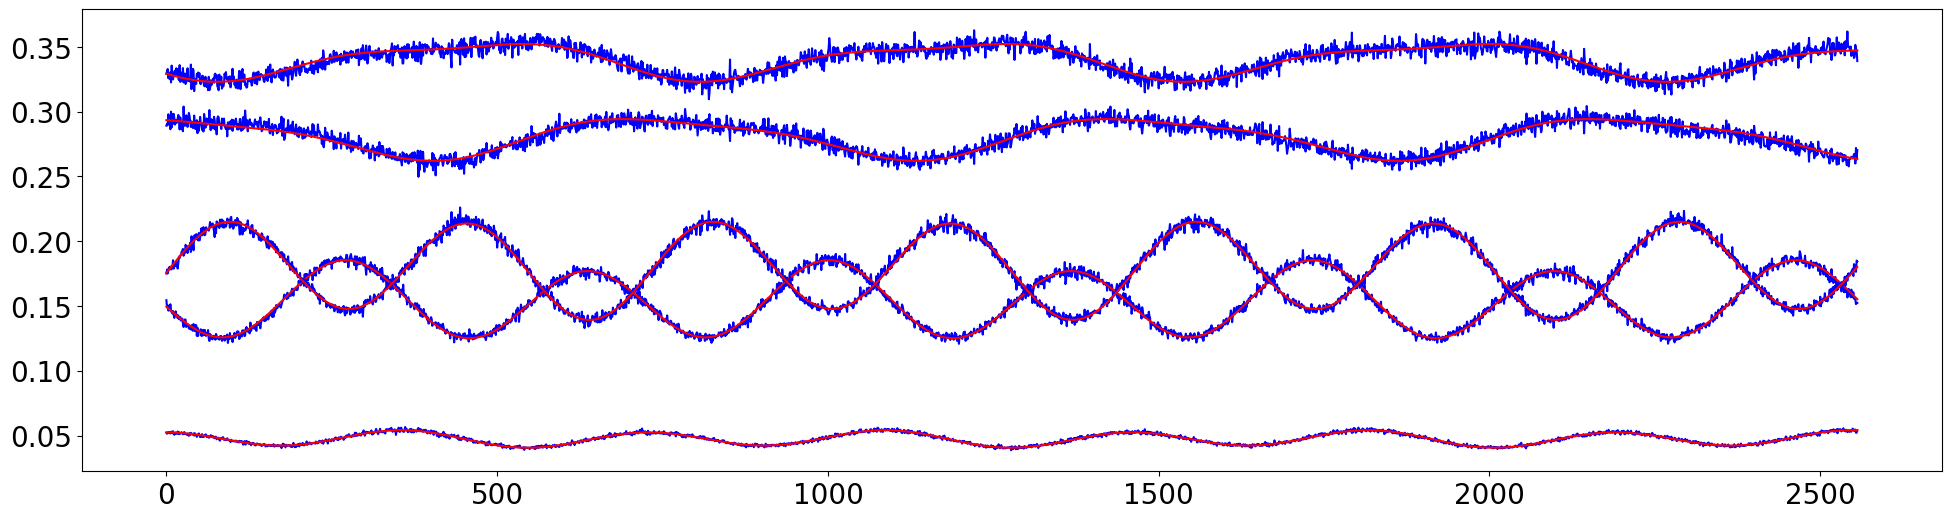

In [11]:
from sklearn.linear_model import Ridge

df_no_can_ken = df[~df.country.isin(('Canada', 'Kenya'))].copy()

total = df_no_can_ken.groupby(by='date').num_sold.sum().rename('num_sold_total')
df_no_can_ken = df_no_can_ken.join(total, on='date', how='left')
df_no_can_ken['num_sold_ratio'] = df_no_can_ken['num_sold'] / df_no_can_ken['num_sold_total']

plt.figure(figsize=(24, 6))
df['product_factor'] = None
for product in CFG.products:
    df_no_can_ken_date = df_no_can_ken[(df_no_can_ken['product'] == product) & (df_no_can_ken['test'] == 0)].groupby(by='date')
    x = df_no_can_ken_date[CFG.sincoscol].mean().to_numpy()
    y = df_no_can_ken_date.num_sold_ratio.sum().to_numpy()

    reg = Ridge()
    reg.fit(x, y)
    p = reg.predict(x)
    df.loc[(df['product'] == product), 'product_factor'] = reg.predict(df.loc[(df['product'] == product), CFG.sincoscol].to_numpy())
   
    plt.plot(y, 'b')
    plt.plot(p, 'r')
plt.show()

In [12]:
df['holiday'] = 0

for country in CFG.countries:
    days = [str(day) for day in holidays.CountryHoliday(CFG.countries_2l[country], years=CFG.years)]
    df.loc[(df.country==country) & (df.date.isin(days)), 'holiday'] = 1

num_sold_per_week_country_weekday = df.groupby(['weeknum', 'country', 'weekday'])['num_sold'].sum().reset_index().pivot(index=['weeknum', 'country'], columns='weekday')
ratio_sold_per_week_country_weekday = num_sold_per_week_country_weekday.apply(lambda row: row/sum(row), axis=1).reset_index()

ratio_weekday = pd.DataFrame(columns=CFG.countries, data=[[0, ]*len(CFG.countries)]*7)

for n, country in enumerate(CFG.countries):
    for d in range(7):
        dt = ratio_sold_per_week_country_weekday.loc[ratio_sold_per_week_country_weekday.country == country, ('num_sold', d)][:-60]
        ratio_weekday.loc[d, country] = dt.median()

ratio_weekday_mean = ratio_weekday.mean(axis=1)
ratio_weekday['mean'] = ratio_weekday_mean

df['weekday_factor'] = df.weekday.map(ratio_weekday_mean)

# The total ratio taking into account all factors
df['ratio'] = df['gdp_factor'] * df['product_factor'] * df['store_factor'] * df['weekday_factor']

# The total sold items taking into account all factors
df['total'] = df['num_sold'] / df['ratio']

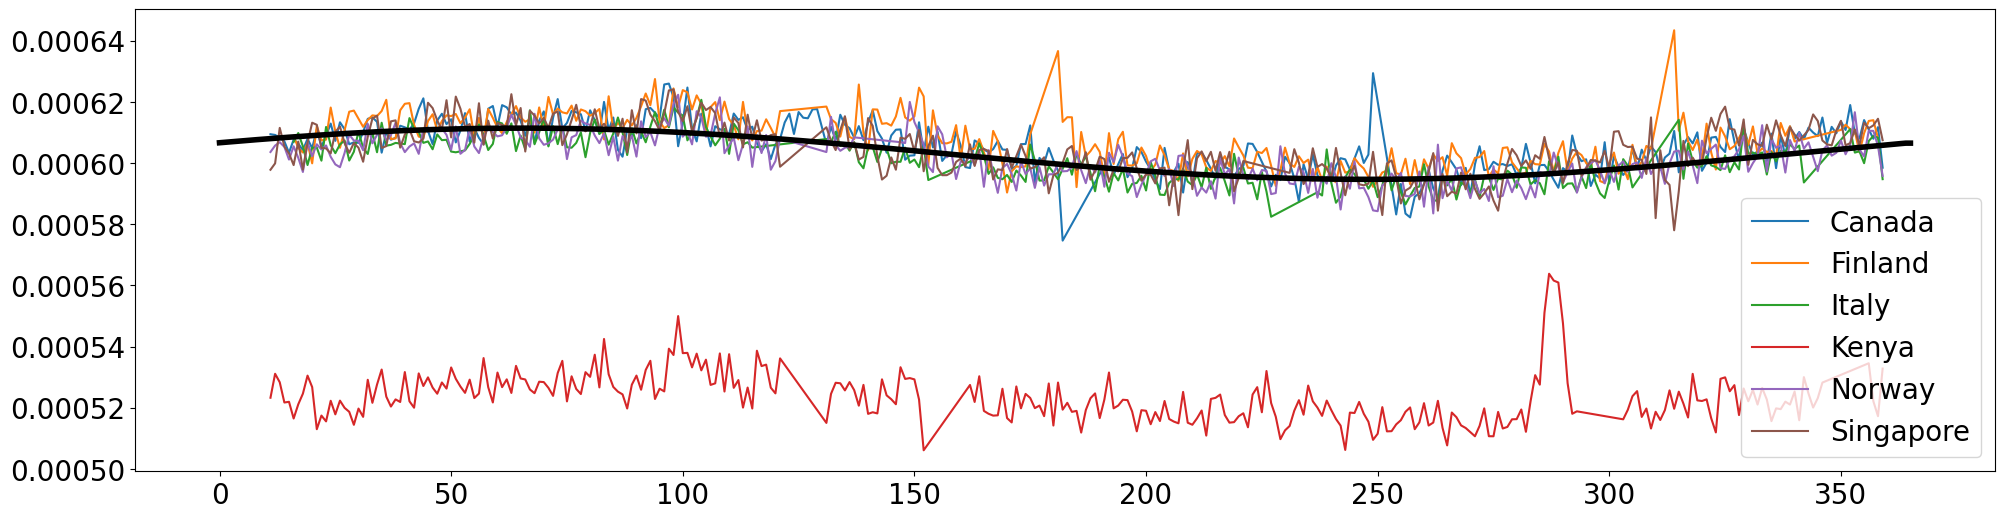

In [13]:
# Exclude holidays
df_holidays = df.copy()
df_holidays['holiday_response'] = 0
for country in CFG.countries:
    for holiday, _ in holidays.CountryHoliday(CFG.countries_2l[country], years=CFG.years).items():
        df_holidays.loc[(df_holidays.country==country) & df_holidays.date.isin(pd.date_range(holiday, periods=CFG.holiday_response_len)), 'holiday_response'] = 1

fig = plt.figure(figsize=(24,6))
data = pd.DataFrame()
for n, country in enumerate(CFG.countries):
    dt = df_holidays[(df_holidays.country==country) & (df_holidays.holiday_response == 0)].groupby(['dayofyear']).total.median()
    data[country]= dt
    plt.plot(dt, label=country)
data['median'] = data.median(axis=1)

# Linear regression on fourier series
x = data.index.to_numpy()
y = data['median'].to_numpy()
fourier = lambda t: np.array([np.sin(2*np.pi/365*t), np.cos(2*np.pi/365*t)])

year_ratio = Ridge(alpha=0.01).fit(fourier(x).T, y.T).predict(fourier(np.arange(1, 366)).T)
year_ratio = np.append(year_ratio, year_ratio[-1])

df['dayofyear_factor'] = df.dayofyear.map(dict(zip(np.arange(1, 367), year_ratio)))

# The total ratio taking into account all factors
df['ratio'] = df['gdp_factor'] * df['product_factor'] * df['store_factor'] * df['weekday_factor'] * df['dayofyear_factor']

# The total sold items taking into account all factors
df['total'] = df['num_sold'] / df['ratio']

plt.plot(year_ratio, 'k', linewidth=4)
plt.legend()

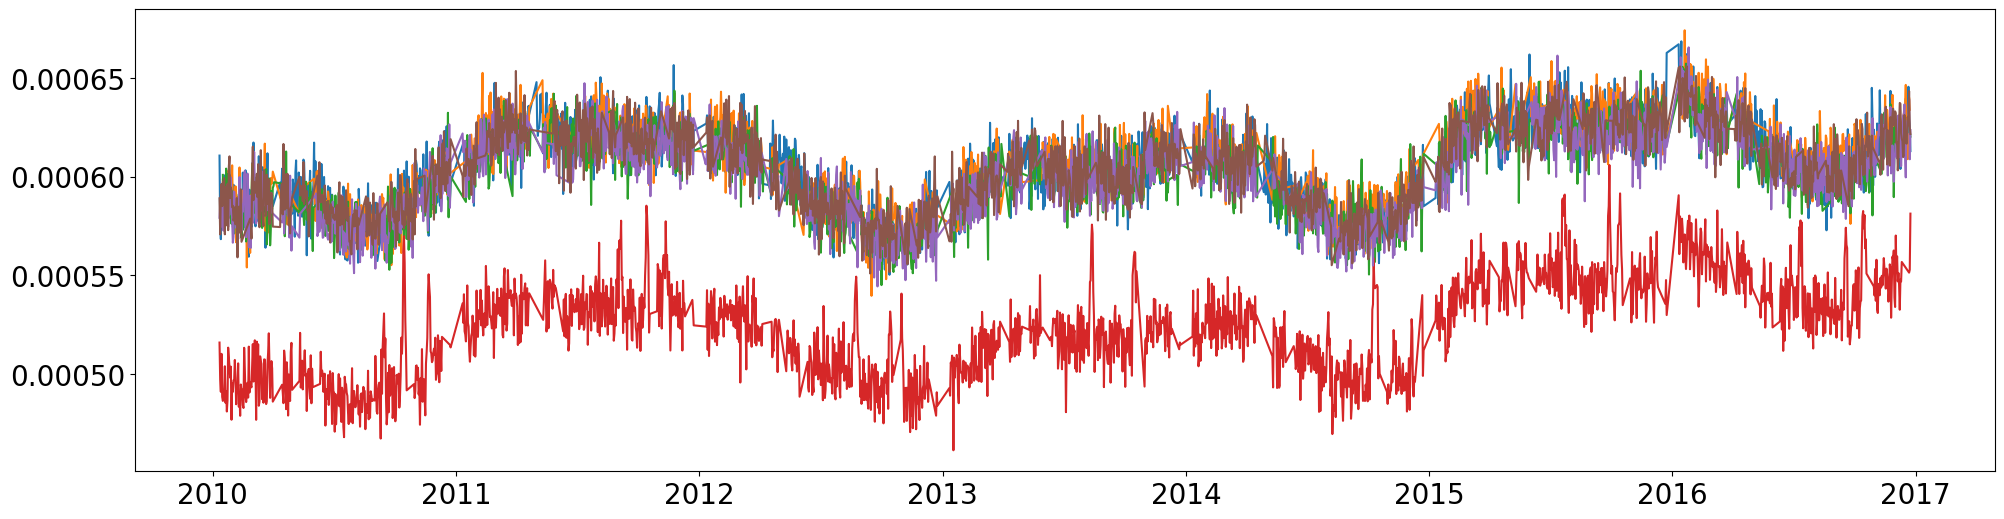

In [14]:
fig = plt.figure(figsize=(24,6))
data = pd.DataFrame()
for n, country in enumerate(CFG.countries):
    dt = df_holidays[(df_holidays.test == 0) & (df_holidays.country==country) & (df_holidays.holiday_response == 0)].groupby(['date']).total.median()
    data[country]= dt
    plt.plot(dt, label=country)
data['median'] = data.median(axis=1)

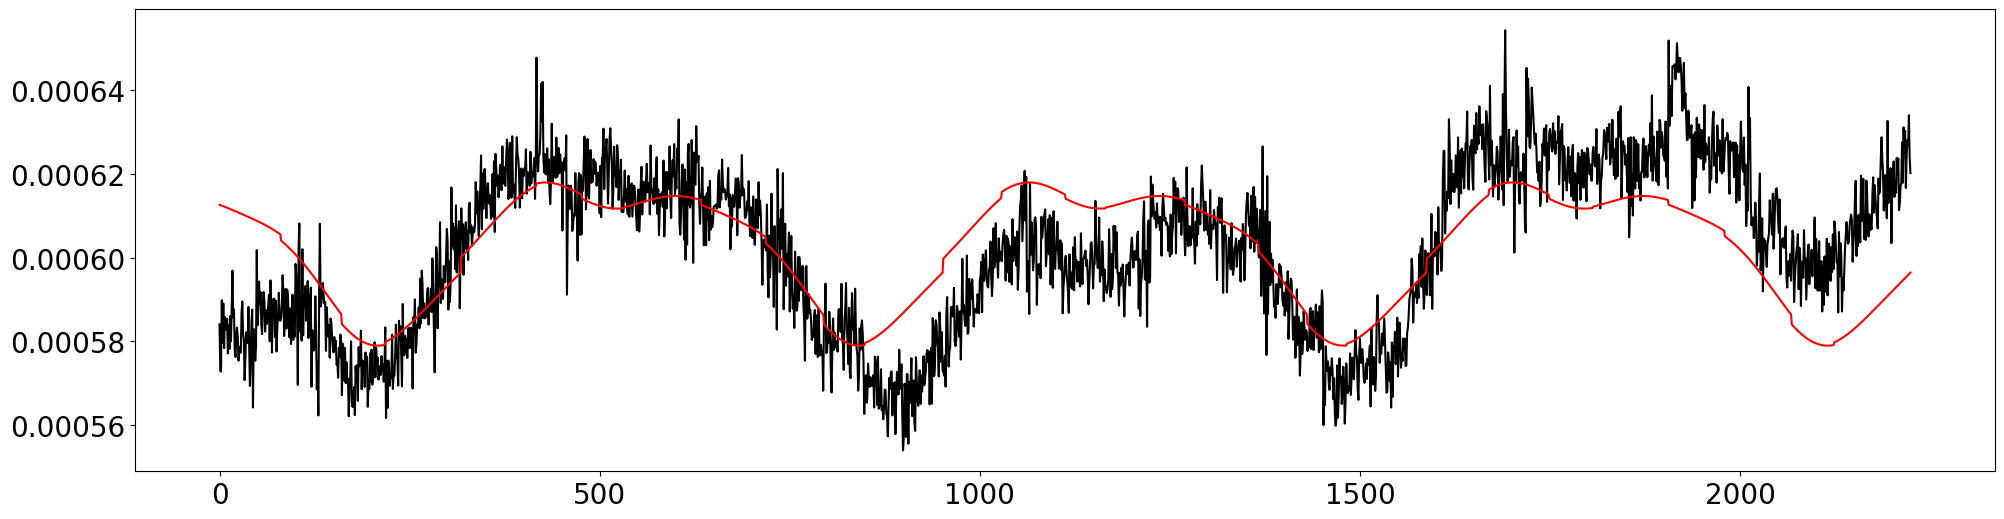

In [15]:
# Linear regression on fourier series
dfsc = df[df.test == 0].groupby('date')[CFG.sincoscol2].mean()#.to_numpy()
dfsc['median'] = data['median']

x = dfsc[~pd.isna(dfsc['median'])][CFG.sincoscol2].to_numpy()
y = dfsc[~pd.isna(dfsc['median'])]['median'].to_numpy()

reg = Ridge(alpha=0.01, fit_intercept=True)
reg.fit(x, y)

fig = plt.figure(figsize=(24,6))
plt.plot(y, 'k')
plt.plot(reg.predict(x), 'r')

df['sincos_factor'] = reg.intercept_ + (df[CFG.sincoscol2] * reg.coef_).sum(axis=1)

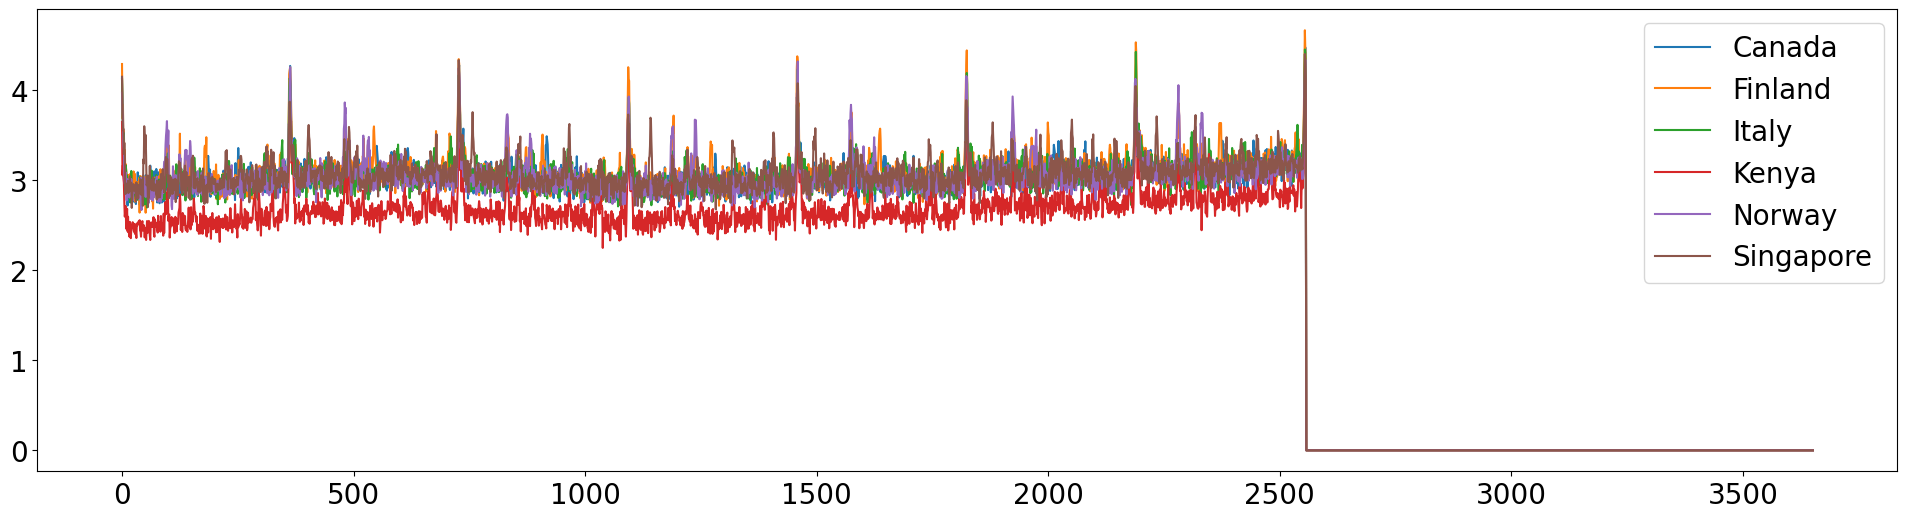

In [16]:
# The total ratio taking into account all factors
df['ratio'] = df['gdp_factor'] * df['product_factor'] * df['store_factor'] * df['weekday_factor'] * df['sincos_factor']

# The total sold items taking into account all factors
df['total'] = df['num_sold'] / df['ratio']

fig = plt.figure(figsize=(24,6))
for c in CFG.countries:
    df_p = df[(df.country == c) & (df['product'] == 'Kaggle')].groupby('date').total.sum().to_numpy()
    plt.plot(df_p, label=c)

plt.legend();

In [17]:
country_factor = df[(df['product'] == 'Kaggle')].groupby('country').total.sum().rename('country_factor')
country_factor = country_factor / country_factor.median()
df = df.join(country_factor, on='country', how='left')

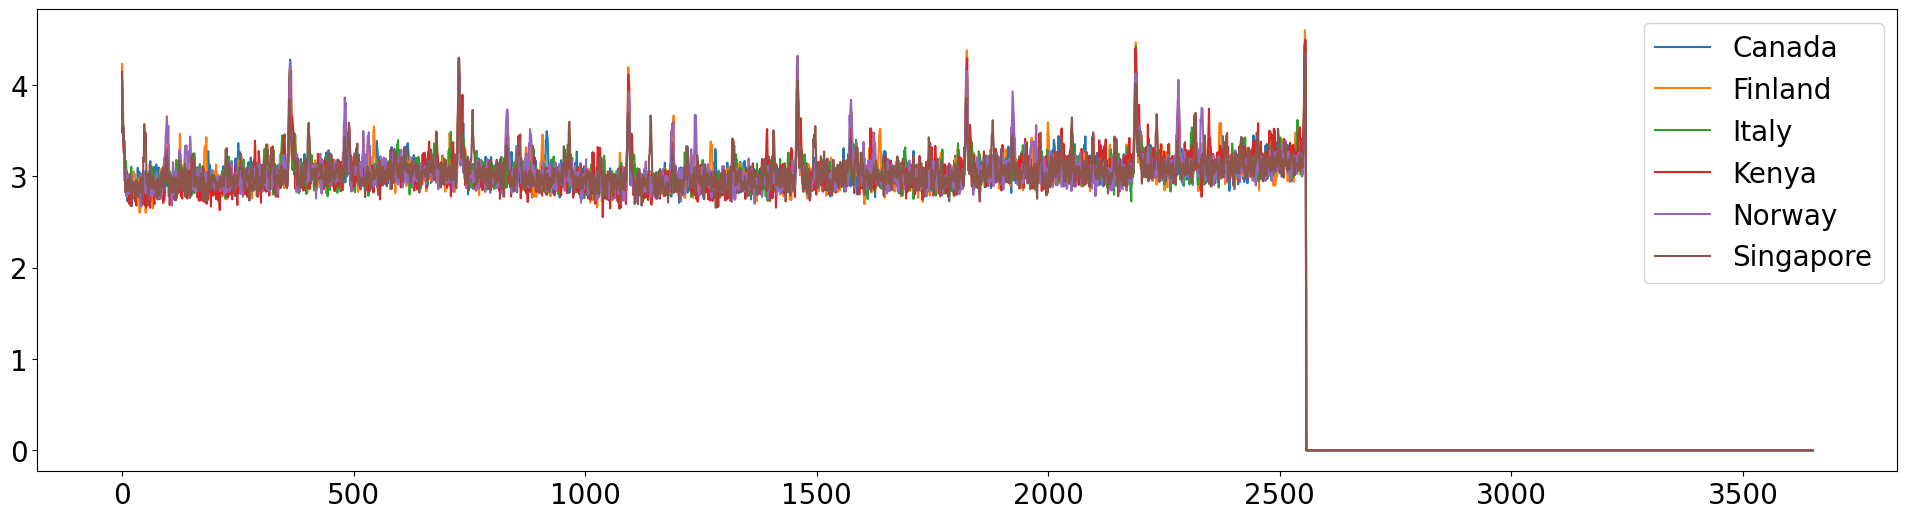

In [18]:
df['ratio'] = df['gdp_factor'] * df['product_factor'] * df['store_factor'] * df['weekday_factor'] * df['sincos_factor'] * df['country_factor']

# The total sold items taking into account all factors
df['total'] = df['num_sold'] / df['ratio']

fig = plt.figure(figsize=(24,6))
for c in CFG.countries:
    df_p = df[(df.country == c) & (df['product'] == 'Kaggle')].groupby('date').total.sum().to_numpy()
    plt.plot(df_p, label=c)

plt.legend();

In [19]:
npdoy_factor = df.groupby('dayofyear').total.median().rename('npdoy_factor')
df = df.join(npdoy_factor, on='dayofyear', how='left')

In [20]:
from sklearn.metrics import mean_absolute_percentage_error
#df['ratio'] = df['gdp_factor'] * df['product_factor'] * df['store_factor'] * df['weekday_factor'] * df['dayofyear_factor'] * df['sincos_factor'] * df['country_factor']
df['ratio'] = df['gdp_factor'] * df['product_factor'] * df['store_factor'] * df['weekday_factor'] * df['sincos_factor'] * df['country_factor']

df['total'] = df['num_sold'] / df['ratio']
const_factor = df['total'].median() * 1.06


In [ ]:

df['prediction'] = const_factor * df['ratio']
mape_train = mean_absolute_percentage_error(df[(df.test == 0) & (~pd.isna(df.num_sold))].num_sold, df[(df.test == 0) & (~pd.isna(df.num_sold))].prediction)

print(f'Without new npdoy_factor {mape_train=}')

In [22]:
df['prediction'] = np.round(df['prediction'].astype(float)).astype(int)

In [25]:
submission = df[(df.test == 1)][['id', 'prediction']].rename(columns={'prediction': 'num_sold'})
submission.to_csv('playground-series-s5e1/decomposition//submission.csv', index=False)

!head submission.csv

id,num_sold
230130,129
230131,830
230132,629
230133,370
230134,432
230135,261
230136,1678
230137,1273
230138,748
